In [22]:
import cv2
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt
% matplotlib inline

# Initializing GPU

In [23]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cuda


# Parameters

In [24]:
DATASET_DIR = '/home/maxim/PycharmProjects/pythonProject/02_Traffic_Sign_Classification/data/traffic_sign_dataset'

NUM_CLASSES = 58

IMAGE_HEIGHT = 128
IMAGE_WIDTH = 128

IMAGE_MEAN = [0.485, 0.456, 0.406]
IMAGE_STD = [0.229, 0.224, 0.225]

BATCH_SIZE = 16
NUM_WORKERS = 2
EPOCHS = 8

# Wrapping for dataset

In [25]:
class TraffiSignDataset(Dataset):
    def __init__(self, dataset_dir: str, image_height: int, image_width: int, train: bool = False):
        super(TraffiSignDataset, self).__init__()
        self.dataset_dir = dataset_dir
        self.image_height = image_height
        self.image_width = image_width
        self.train = train

        dir_suffix = 'train' if self.train else 'test'
        label_name = 'TsignRecgTrain4170Annotation.txt' if self.train else 'TsignRecgTest1994Annotation.txt'

        self.image_dir = f'{self.dataset_dir}/images_{dir_suffix}/'
        self.label_path = f'{self.dataset_dir}/annotations_{dir_suffix}/{label_name}'

        self.image_names, self.x1y1x2y2s, self.labels = self._load_labels(self.label_path)

        self.transform = transforms.Compose(
            [
                transforms.ToTensor(),
                transforms.Normalize(IMAGE_MEAN, IMAGE_STD),
            ]
        )

    @staticmethod
    def _load_labels(path):
        with open(path, 'r') as f:
            labels = f.readlines()
        labels = [label.strip().split(';') for label in labels]
        image_names = [label[0] for label in labels]
        x1y1x2y2s = [(int(label[3]), int(label[4]), int(label[5]), int(label[6])) for label in labels]
        labels = [int(label[-2]) for label in labels]
        return image_names, x1y1x2y2s, labels

    def __getitem__(self, index):
        image = self.get_np_image(index)
        image = np.array(image / 255, dtype=np.float32)
        image = self.transform(image)
        label = self.labels[index]
        return image, label

    def get_np_image(self, index):
        image = cv2.imread(f'{self.image_dir}/{self.image_names[index]}')
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        x1, y1, x2, y2 = self.x1y1x2y2s[index]
        image = image[y1: y2, x1: x2, ...]
        image = cv2.resize(image, (self.image_width, self.image_height), interpolation=cv2.INTER_CUBIC)
        return image

    def __len__(self):
        return len(self.image_names)

In [26]:
def create_dataloader(dataset: Dataset, batch_size: int, num_workers: int, train: bool = False):
    return DataLoader(
        dataset=dataset, batch_size=batch_size,
        shuffle=train, num_workers=num_workers,
        pin_memory=True, drop_last=False)


def evaluate(model: nn.Module, dataloader: DataLoader, train: bool = False):
    model.eval()

    correct = 0
    total = 0

    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for data in dataloader:
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            # calculate outputs by running images through the network
            outputs = model(inputs)
            # the class with the highest energy is what we choose as prediction
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    images = len(dataloader) * dataloader.batch_size
    prefix = "train" if train else "test"
    print(f'Accuracy of the network on the {images} {prefix} images: {(100 * correct / total):.2f} %')


def plot(imgs, with_orig=True, row_title=None, **imshow_kwargs):
    if not isinstance(imgs[0], list):
        # Make a 2d grid even if there's just 1 row
        imgs = [imgs]

    num_rows = len(imgs)
    num_cols = len(imgs[0])
    fig, axs = plt.subplots(nrows=num_rows, ncols=num_cols, squeeze=False)
    for row_idx, row in enumerate(imgs):
        for col_idx, img in enumerate(row):
            ax = axs[row_idx, col_idx]
            ax.imshow(np.asarray(img), **imshow_kwargs)
            ax.set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

    if row_title is not None:
        for row_idx in range(num_rows):
            axs[row_idx, 0].set(ylabel=row_title[row_idx])

    plt.tight_layout()

# Dataset instances

In [27]:
train_dataset = TraffiSignDataset(
    dataset_dir=DATASET_DIR, image_height=IMAGE_HEIGHT, image_width=IMAGE_WIDTH, train=True)

test_dataset = TraffiSignDataset(
    dataset_dir=DATASET_DIR, image_height=IMAGE_HEIGHT, image_width=IMAGE_WIDTH)

train_dataloader = create_dataloader(
    train_dataset, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, train=True)

test_dataloader = create_dataloader(
    test_dataset, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS)

# Data samples

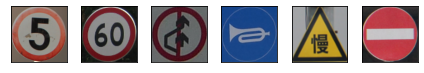

In [28]:
indices = [0, 200, 400, 600, 800, 1000]
plot([train_dataset.get_np_image(index) for index in indices]);

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


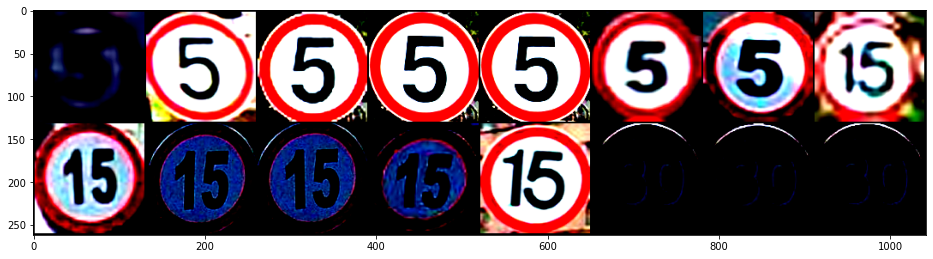

In [29]:
images, _ = next(iter(test_dataloader))
plt.figure(figsize=(16, 8))
plt.imshow(torchvision.utils.make_grid(images).permute(1, 2, 0));

# Models training and evaluation

## Baseline

In [30]:
class TrafficSignClassifier(nn.Module):
    def __init__(self, num_classes: int):
        super(TrafficSignClassifier, self).__init__()
        self.conv1 = torch.nn.Conv2d(3, 6, 5)
        self.pool = torch.nn.MaxPool2d(2, 2)
        self.conv2 = torch.nn.Conv2d(6, 64, 5)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc1 = torch.nn.Linear(64, 120)
        self.fc2 = torch.nn.Linear(120, 84)
        self.fc3 = torch.nn.Linear(84, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [31]:
model = TrafficSignClassifier(num_classes=NUM_CLASSES)
model.to(device)
x = torch.randn(1, 3, 128, 128).to(device)
print(model(x).shape)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

print(model)

torch.Size([1, 58])
TrafficSignClassifier(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 64, kernel_size=(5, 5), stride=(1, 1))
  (avgpool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc1): Linear(in_features=64, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=58, bias=True)
)


### Training

In [32]:
model.train()

for epoch in range(EPOCHS):  # loop over the dataset multiple times
    running_loss = 0.0

    for i, data in enumerate(train_dataloader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        # zero the parameter gradients
        optimizer.zero_grad()
        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        # print statistics
        running_loss += loss.item()
        if i % 100 == 99:  # print every 100 mini-batches
            print(f'epoch: {epoch:2d}, iteration: {i + 1:4d}, loss: {running_loss / 100:.3f}')
            running_loss = 0.0

model.eval();

epoch:  0, iteration:  100, loss: 4.065
epoch:  0, iteration:  200, loss: 4.021
epoch:  1, iteration:  100, loss: 3.915
epoch:  1, iteration:  200, loss: 3.624
epoch:  2, iteration:  100, loss: 3.327
epoch:  2, iteration:  200, loss: 3.113
epoch:  3, iteration:  100, loss: 2.956
epoch:  3, iteration:  200, loss: 2.858
epoch:  4, iteration:  100, loss: 2.807
epoch:  4, iteration:  200, loss: 2.753
epoch:  5, iteration:  100, loss: 2.742
epoch:  5, iteration:  200, loss: 2.670
epoch:  6, iteration:  100, loss: 2.596
epoch:  6, iteration:  200, loss: 2.664
epoch:  7, iteration:  100, loss: 2.554
epoch:  7, iteration:  200, loss: 2.609


### Saving_model

In [33]:
torch.save(model.state_dict(), './traffic_sign_classifier_baseline.pth')

### Evaluation

In [34]:
evaluate(model, train_dataloader, train=True)

Accuracy of the network on the 4176 train images: 31.32 %


In [ ]:
evaluate(model, test_dataloader, train=False)

# VGG

In [35]:
VGG16 = [64, 64, 'MaxPool', 128, 128, 'MaxPool', 256, 256, 256, 'MaxPool', 512, 512, 512, 'MaxPool', 512, 512, 512,
         'MaxPool']


class VGGTrafficSignClassifier(nn.Module):
    def __init__(self, in_channels: int, num_classes: int, architecture: list):
        super().__init__()
        self.in_channels = in_channels
        self.conv_layers = self._create_conv_layers(architecture)
        self.fc_layers = nn.Sequential(
            nn.Linear(512 * 4 * 4, 4096),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(4096, num_classes)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.reshape(x.shape[0], -1)
        x = self.fc_layers(x)
        return x

    def _create_conv_layers(self, architecture: list):
        layers = list()
        in_channels = self.in_channels
        for l in architecture:
            if isinstance(l, int):
                out_channels = l
                layers.extend([nn.Conv2d(in_channels=in_channels, out_channels=out_channels,
                                         kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
                               nn.BatchNorm2d(l),
                               nn.ReLU()])
                in_channels = l
            elif l == 'MaxPool':
                layers.append(nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2)))

        return nn.Sequential(*layers)

In [36]:
model = VGGTrafficSignClassifier(num_classes=NUM_CLASSES, in_channels=3, architecture=VGG16)
model.to(device)
x = torch.randn(1, 3, 128, 128).to(device)
print(model(x).shape)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

print(model)

torch.Size([1, 58])
VGGTrafficSignClassifier(
  (conv_layers): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU()
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU()
    (13): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (14):

### Training

In [37]:
model.train()

for epoch in range(EPOCHS):  # loop over the dataset multiple times
    running_loss = 0.0

    for i, data in enumerate(train_dataloader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        # zero the parameter gradients
        optimizer.zero_grad()
        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        # print statistics
        running_loss += loss.item()
        if i % 100 == 99:  # print every 100 mini-batches
            print(f'epoch: {epoch:2d}, iteration: {i + 1:4d}, loss: {running_loss / 100:.3f}')
            running_loss = 0.0

model.eval();

epoch:  0, iteration:  100, loss: 3.159
epoch:  0, iteration:  200, loss: 2.022
epoch:  1, iteration:  100, loss: 0.931
epoch:  1, iteration:  200, loss: 0.642
epoch:  2, iteration:  100, loss: 0.352
epoch:  2, iteration:  200, loss: 0.267
epoch:  3, iteration:  100, loss: 0.099
epoch:  3, iteration:  200, loss: 0.100
epoch:  4, iteration:  100, loss: 0.038
epoch:  4, iteration:  200, loss: 0.034
epoch:  5, iteration:  100, loss: 0.025
epoch:  5, iteration:  200, loss: 0.018
epoch:  6, iteration:  100, loss: 0.028
epoch:  6, iteration:  200, loss: 0.012
epoch:  7, iteration:  100, loss: 0.005
epoch:  7, iteration:  200, loss: 0.004


### Saving model

In [38]:
torch.save(model.state_dict(), './traffic_sign_classifier_vgg16.pth')

### Evaluation

In [39]:
evaluate(model, train_dataloader, train=True)

Accuracy of the network on the 4176 train images: 100.00 %


In [40]:
evaluate(model, test_dataloader, train=False)

Accuracy of the network on the 2000 test images: 99.20 %


## ResNet

In [41]:
from typing import List


class Block(nn.Module):
    def __init__(self, in_channels: int, out_channels: int, identity_downsample=None, stride: int = 1):
        super().__init__()
        self.expansion = 4
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.conv3 = nn.Conv2d(out_channels, out_channels * self.expansion, kernel_size=1, stride=1, padding=0)
        self.bn3 = nn.BatchNorm2d(out_channels * self.expansion)
        self.relu = nn.ReLU()
        self.identity_downsample = identity_downsample

    def forward(self, x: torch.Tensor):
        identity = x.clone()

        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)

        x = self.conv3(x)
        x = self.bn3(x)

        if self.identity_downsample is not None:
            identity = self.identity_downsample(identity)

        x += identity
        x = self.relu(x)

        return x


class ResNet(nn.Module):  # [3, 4, 6, 3]
    def __init__(self, block: Block, layers: List[int], image_channels: int, num_classes: int):
        super().__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(image_channels, 64, kernel_size=7, stride=2, padding=3)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._make_layers(block, layers[0], out_channels=64, stride=1)
        self.layer2 = self._make_layers(block, layers[1], out_channels=128, stride=2)
        self.layer3 = self._make_layers(block, layers[2], out_channels=256, stride=2)
        self.layer4 = self._make_layers(block, layers[3], out_channels=512, stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * 4, num_classes)

    def _make_layers(self, block: Block, num_residual_blocks: int, out_channels: int, stride: int):
        identity_downsample = None
        layers = list()

        if stride != 1 or self.in_channels != out_channels * 4:
            identity_downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels * 4, kernel_size=1, stride=stride),
                nn.BatchNorm2d(out_channels * 4)
            )

        layers.append(block(self.in_channels, out_channels, identity_downsample, stride))
        self.in_channels = out_channels * 4

        for i in range(num_residual_blocks - 1):
            layers.append(block(self.in_channels, out_channels))

        return nn.Sequential(*layers)

    def forward(self, x: torch.Tensor):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.reshape(x.shape[0], -1)
        x = self.fc(x)

        return x


def resnet_50(img_channels: int = 3, num_classes: int = NUM_CLASSES):
    return ResNet(Block, [3, 4, 6, 3], img_channels, num_classes)


def test():
    net = resnet_50()
    x = torch.randn(1, 3, 128, 128)
    print(net(x).size())


test()

torch.Size([1, 58])


In [42]:
model = resnet_50()
model.to(device)

x = torch.randn(1, 3, 128, 128).to(device)
print(model(x).shape)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

print(model)

torch.Size([1, 58])
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Block(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1))
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
      (identity_downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1))
        (1): BatchNorm2d(256, eps=1e-05, mom

### Training

In [43]:
model.train()

for epoch in range(EPOCHS):  # loop over the dataset multiple times
    running_loss = 0.0

    for i, data in enumerate(train_dataloader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        # zero the parameter gradients
        optimizer.zero_grad()
        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        # print statistics
        running_loss += loss.item()
        if i % 100 == 99:  # print every 100 mini-batches
            print(f'epoch: {epoch:2d}, iteration: {i + 1:4d}, loss: {running_loss / 100:.3f}')
            running_loss = 0.0

model.eval();

epoch:  0, iteration:  100, loss: 3.430
epoch:  0, iteration:  200, loss: 2.317
epoch:  1, iteration:  100, loss: 1.014
epoch:  1, iteration:  200, loss: 0.646
epoch:  2, iteration:  100, loss: 0.320
epoch:  2, iteration:  200, loss: 0.191
epoch:  3, iteration:  100, loss: 0.105
epoch:  3, iteration:  200, loss: 0.091
epoch:  4, iteration:  100, loss: 0.049
epoch:  4, iteration:  200, loss: 0.028
epoch:  5, iteration:  100, loss: 0.022
epoch:  5, iteration:  200, loss: 0.030
epoch:  6, iteration:  100, loss: 0.018
epoch:  6, iteration:  200, loss: 0.019
epoch:  7, iteration:  100, loss: 0.011
epoch:  7, iteration:  200, loss: 0.009


### Saving model

In [44]:
torch.save(model.state_dict(), './traffic_sign_classifier_resnet.pth')

### Evaluation

In [45]:
evaluate(model, train_dataloader, train=True)

Accuracy of the network on the 4176 train images: 100.00 %


In [46]:
evaluate(model, test_dataloader, train=False)

Accuracy of the network on the 2000 test images: 90.17 %


## GoogLeNet / InceptionNet

In [54]:
import torch
import torch.nn as nn


class ConvBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int, **kwargs):
        super().__init__()
        self.relu = nn.ReLU()
        self.conv = nn.Conv2d(in_channels, out_channels, **kwargs)
        self.bn = nn.BatchNorm2d(out_channels)

    def forward(self, x: torch.Tensor):
        return self.relu(self.bn(self.conv(x)))


class InceptionBlock(nn.Module):
    def __init__(self, in_channels: int, out_chn_1x1: int, red_chn_3x3: int, out_chn_3x3: int, red_chn_5x5: int,
                 out_chn_5x5: int, out_chn_1x1pool: int):
        super().__init__()

        self.branch1 = ConvBlock(in_channels, out_chn_1x1, kernel_size=1)
        self.branch2 = nn.Sequential(
            ConvBlock(in_channels, red_chn_3x3, kernel_size=1),
            ConvBlock(red_chn_3x3, out_chn_3x3, kernel_size=3, padding=1)
        )
        self.branch3 = nn.Sequential(
            ConvBlock(in_channels, red_chn_5x5, kernel_size=1),
            ConvBlock(red_chn_5x5, out_chn_5x5, kernel_size=5, padding=2)
        )
        self.branch4 = nn.Sequential(
            nn.MaxPool2d(kernel_size=3, stride=1, padding=1),
            ConvBlock(in_channels, out_chn_1x1pool, kernel_size=1)
        )

    def forward(self, x: torch.Tensor):
        return torch.cat([self.branch1(x), self.branch2(x), self.branch3(x), self.branch4(x)], 1)


class GoogleNet(nn.Module):
    def __init__(self, in_channels: int = 3, num_classes: int = NUM_CLASSES):
        super().__init__()
        self.preprocess = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224)]
        )
        self.conv1 = ConvBlock(in_channels, out_channels=64, kernel_size=7, stride=2, padding=3)
        self.maxpool1 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.conv2 = ConvBlock(in_channels=64, out_channels=192, kernel_size=3, stride=1, padding=1)
        self.maxpool2 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # Inception blocks
        self.inception3a = InceptionBlock(192, 64, 96, 128, 16, 32, 32)
        self.inception3b = InceptionBlock(256, 128, 128, 192, 32, 96, 64)
        self.maxpool3 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.inception4a = InceptionBlock(480, 192, 96, 208, 16, 48, 64)
        self.inception4b = InceptionBlock(512, 160, 112, 224, 24, 64, 64)
        self.inception4c = InceptionBlock(512, 128, 128, 256, 24, 64, 64)
        self.inception4d = InceptionBlock(512, 112, 144, 288, 32, 64, 64)
        self.inception4e = InceptionBlock(528, 256, 160, 320, 32, 128, 128)
        self.maxpool4 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.inception5a = InceptionBlock(832, 256, 160, 320, 32, 128, 128)
        self.inception5b = InceptionBlock(832, 384, 192, 384, 48, 128, 128)

        self.avgpool = nn.AvgPool2d(kernel_size=7, stride=1)
        self.dropout = nn.Dropout(p=0.4)
        self.fc1 = nn.Linear(1024, num_classes)

    def forward(self, x: torch.Tensor):
        x = self.preprocess(x)
        x = self.conv1(x)
        x = self.maxpool1(x)
        x = self.conv2(x)
        x = self.maxpool2(x)

        x = self.inception3a(x)
        x = self.inception3b(x)
        x = self.maxpool3(x)

        x = self.inception4a(x)
        x = self.inception4b(x)
        x = self.inception4c(x)
        x = self.inception4d(x)
        x = self.inception4e(x)
        x = self.maxpool4(x)

        x = self.inception5a(x)
        x = self.inception5b(x)
        x = self.avgpool(x)

        x = x.reshape(x.shape[0], -1)
        x = self.dropout(x)
        x = self.fc1(x)

        return x


torch.Size([3, 58])


In [55]:
model = resnet_50()
model.to(device)

x = torch.randn(1, 3, 128, 128).to(device)
print(model(x).shape)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

print(model)

torch.Size([1, 58])
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Block(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1))
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
      (identity_downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1))
        (1): BatchNorm2d(256, eps=1e-05, mom

### Training

In [56]:
model.train()

for epoch in range(EPOCHS):  # loop over the dataset multiple times
    running_loss = 0.0

    for i, data in enumerate(train_dataloader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        # zero the parameter gradients
        optimizer.zero_grad()
        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        # print statistics
        running_loss += loss.item()
        if i % 100 == 99:  # print every 100 mini-batches
            print(f'epoch: {epoch:2d}, iteration: {i + 1:4d}, loss: {running_loss / 100:.3f}')
            running_loss = 0.0

model.eval();

epoch:  0, iteration:  100, loss: 3.427
epoch:  0, iteration:  200, loss: 2.385
epoch:  1, iteration:  100, loss: 1.235
epoch:  1, iteration:  200, loss: 0.611
epoch:  2, iteration:  100, loss: 0.312
epoch:  2, iteration:  200, loss: 0.229
epoch:  3, iteration:  100, loss: 0.115
epoch:  3, iteration:  200, loss: 0.067
epoch:  4, iteration:  100, loss: 0.034
epoch:  4, iteration:  200, loss: 0.031
epoch:  5, iteration:  100, loss: 0.027
epoch:  5, iteration:  200, loss: 0.026
epoch:  6, iteration:  100, loss: 0.025
epoch:  6, iteration:  200, loss: 0.028
epoch:  7, iteration:  100, loss: 0.025
epoch:  7, iteration:  200, loss: 0.015


### Saving model

In [57]:
torch.save(model.state_dict(), './traffic_sign_classifier_inceptionnet.pth')

### Evaluation

In [58]:
evaluate(model, train_dataloader, train=True)

Accuracy of the network on the 4176 train images: 99.76 %


In [59]:
evaluate(model, test_dataloader, train=False)

Accuracy of the network on the 2000 test images: 91.57 %
